### Particle Filtering or "Predict, resample, estimate"
Source:
+ https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb
+ https://habr.com/ru/articles/276801/ (ru)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats
from numpy.random import seed

1.999 when GDP predict is -0.085, # of weights 373, Output Gap value -0.057
2.006 when GDP predict is 1.763, # of weights 355, Output Gap value 1.180
2.015 when GDP predict is 1.640, # of weights 352, Output Gap value 1.106
1.998 when GDP predict is 1.494, # of weights 348, Output Gap value 1.001
1.998 when GDP predict is 1.414, # of weights 347, Output Gap value 0.942
2.016 when GDP predict is 1.353, # of weights 346, Output Gap value 0.888
2.008 when GDP predict is 1.246, # of weights 344, Output Gap value 0.835
1.995 when GDP predict is 1.179, # of weights 344, Output Gap value 0.791
2.005 when GDP predict is 1.118, # of weights 342, Output Gap value 0.746


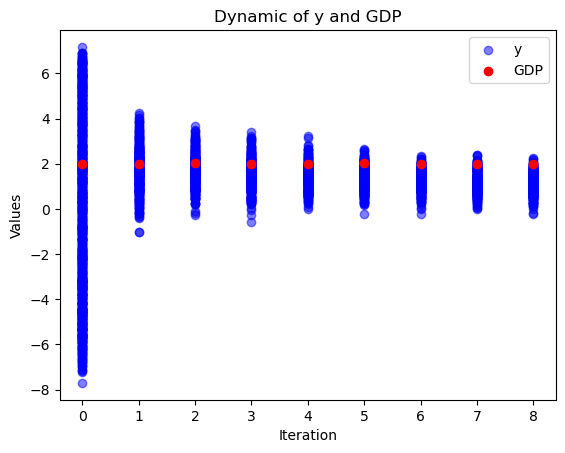

In [6]:
np.random.seed(42)  # for reproducibility
periods = 10
GDP = np.random.normal(2, 0.01, periods)
N = 1000
theta = 0.3
epsilon = 0.1
# initial x values
x = np.random.uniform(-5, 5, N)
# initializing weights uniformly
weights = np.ones(N) / N

for i in range (periods - 1):
    size = len(weights[weights > 0])
    x = np.random.choice(x, size=size, p=weights)
    x = 0.9 * x + np.random.normal(0, epsilon, len(x))
    y = 1.5 * x + np.random.normal(0, theta, len(x))
    # update weights
    weights = scipy.stats.norm.pdf(y, loc=GDP[i+1])
    weights /= np.sum(weights)
    weights[weights < 1/size/5] = 0 # drop values with low weights
    weights /= np.sum(weights)
    print(f"{GDP[i+1]:.3f} when GDP predict is {y.mean():.3f}, # of weights {len(weights[weights > 0])}, Output Gap value {x.mean():.3f}")
    plt.scatter([i] * size, y, color='blue', alpha=0.5, label='y' if i == 0 else "")
    plt.scatter(i, GDP[i+1], color='red', label='GDP' if i == 0 else "")

plt.xlabel("Iteration")
plt.ylabel("Values")
plt.title("Dynamic of y and GDP")
plt.legend()
plt.show()

Period 1
  GDP: 1.999, Predicted GDP: 1.968
  Active particles: 138
  Output Gap estimate: 1.309
  Parameter estimates: phi=0.911, alpha=1.567, process_noise=0.093, measurement_noise=0.305

Period 2
  GDP: 2.006, Predicted GDP: 2.049
  Active particles: 86
  Output Gap estimate: 1.334
  Parameter estimates: phi=0.967, alpha=1.604, process_noise=0.090, measurement_noise=0.259

Period 3
  GDP: 2.015, Predicted GDP: 2.036
  Active particles: 65
  Output Gap estimate: 1.307
  Parameter estimates: phi=0.987, alpha=1.612, process_noise=0.083, measurement_noise=0.213

Period 4
  GDP: 1.998, Predicted GDP: 1.986
  Active particles: 46
  Output Gap estimate: 1.309
  Parameter estimates: phi=1.009, alpha=1.621, process_noise=0.087, measurement_noise=0.181

Period 5
  GDP: 1.998, Predicted GDP: 1.994
  Active particles: 35
  Output Gap estimate: 1.421
  Parameter estimates: phi=0.999, alpha=1.507, process_noise=0.097, measurement_noise=0.165

Period 6
  GDP: 2.016, Predicted GDP: 2.029
  Active p

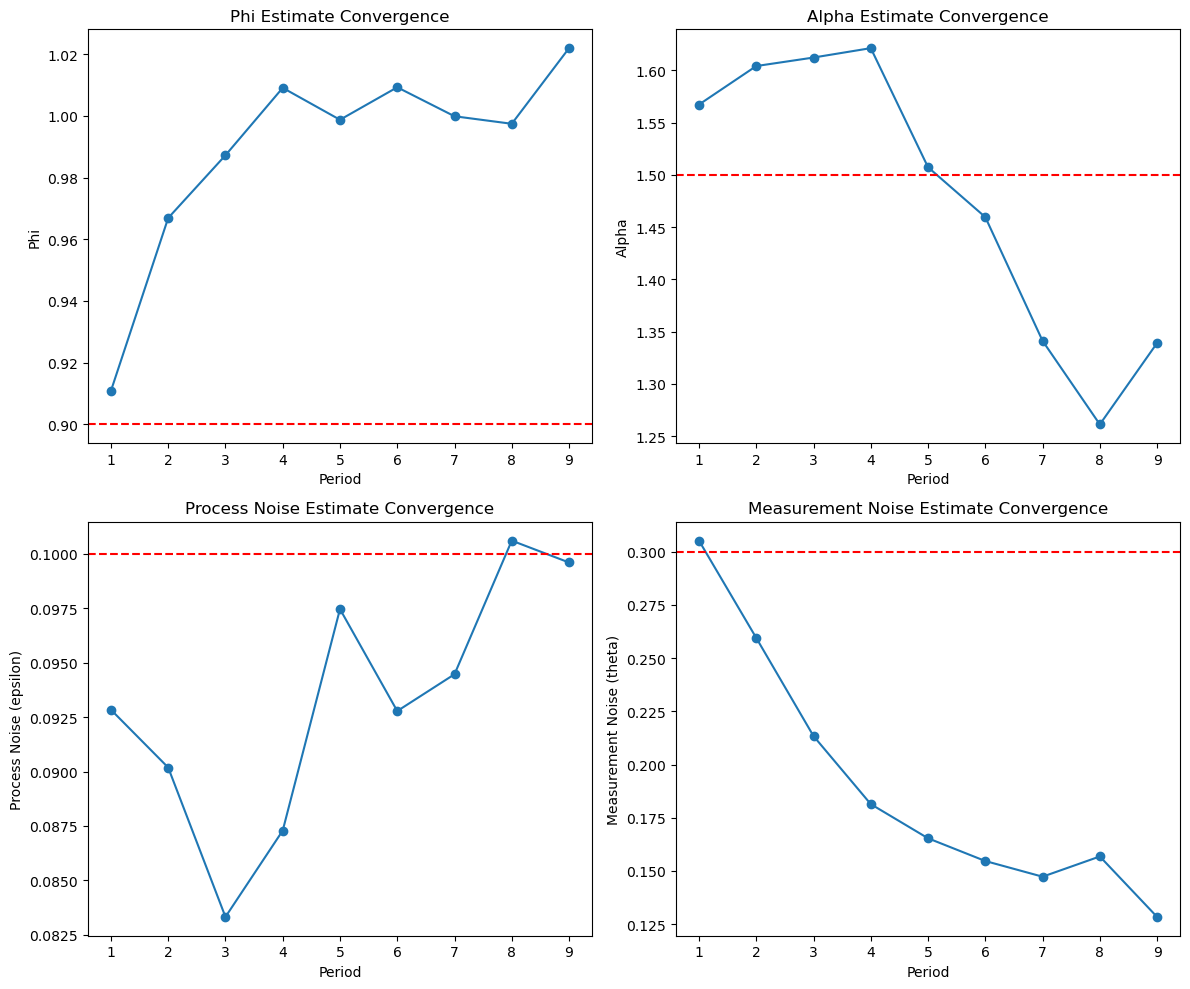

Final Parameter Estimates:
Phi (true=0.9): 1.0219
Alpha (true=1.5): 1.3391
Process Noise (true=0.1): 0.0996
Measurement Noise (true=0.3): 0.1284


In [10]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

# Simulation settings
periods = 10
N = 1000  # Number of particles
true_phi = 0.9  # True autoregressive parameter (hidden)
true_alpha = 1.5  # True measurement equation parameter (hidden)
true_epsilon = 0.1  # True process noise (hidden)
true_theta = 0.3  # True measurement noise (hidden)

# Generate synthetic GDP data (assumed to be observed)
GDP = np.random.normal(2, 0.01, periods)

# Initialize particles for both state and parameters
# Each particle now contains state x and parameters (phi, alpha, process_noise, measurement_noise)
x = np.random.uniform(-5, 5, N)  # Initial state values
phi = np.random.uniform(0.7, 1.1, N)  # Initial phi values
alpha = np.random.uniform(1.0, 2.0, N)  # Initial alpha values
process_noise = np.random.uniform(0.05, 0.15, N)  # Initial process noise values
measurement_noise = np.random.uniform(0.1, 0.5, N)  # Initial measurement noise values

# Initial weights (uniform)
weights = np.ones(N) / N

# Storage for parameter estimates
phi_estimates = []
alpha_estimates = []
process_noise_estimates = []
measurement_noise_estimates = []

# Run particle filter
for i in range(periods - 1):
    # Keep only particles with non-zero weights
    active_indices = np.where(weights > 0)[0]
    size = len(active_indices)
    
    # Resample particles based on weights
    indices = np.random.choice(active_indices, size=size, p=weights[active_indices]/np.sum(weights[active_indices]))
    x = x[indices]
    phi = phi[indices]
    alpha = alpha[indices]
    process_noise = process_noise[indices]
    measurement_noise = measurement_noise[indices]
    
    # Add small perturbations to parameters (parameter exploration)
    phi += np.random.normal(0, 0.01, size)
    alpha += np.random.normal(0, 0.02, size)
    process_noise = np.abs(process_noise + np.random.normal(0, 0.005, size))  # Keep noise positive
    measurement_noise = np.abs(measurement_noise + np.random.normal(0, 0.01, size))  # Keep noise positive
    
    # State transition - using each particle's phi and process_noise
    x = np.array([phi[j] * x[j] + np.random.normal(0, process_noise[j]) for j in range(size)])
    
    # Generate observations - using each particle's alpha and measurement_noise
    y = np.array([alpha[j] * x[j] + np.random.normal(0, measurement_noise[j]) for j in range(size)])
    
    # Update weights based on likelihood of observed GDP given particle parameters
    weights = np.zeros(N)
    for j in range(size):
        weights[j] = scipy.stats.norm.pdf(GDP[i+1], loc=y[j], scale=measurement_noise[j])
    
    # Normalize weights
    weights /= np.sum(weights)
    
    # Remove particles with very low weights
    threshold = 1/size/5
    weights[weights < threshold] = 0
    weights /= np.sum(weights)
    
    # Calculate weighted parameter estimates
    phi_est = np.sum(phi * weights[:size])
    alpha_est = np.sum(alpha * weights[:size])
    process_noise_est = np.sum(process_noise * weights[:size])
    measurement_noise_est = np.sum(measurement_noise * weights[:size])
    
    # Store parameter estimates
    phi_estimates.append(phi_est)
    alpha_estimates.append(alpha_est)
    process_noise_estimates.append(process_noise_est)
    measurement_noise_estimates.append(measurement_noise_est)
    
    # Print current estimates
    print(f"Period {i+1}")
    print(f"  GDP: {GDP[i+1]:.3f}, Predicted GDP: {np.sum(y * weights[:size]):.3f}")
    print(f"  Active particles: {len(weights[weights > 0])}")
    print(f"  Output Gap estimate: {np.sum(x * weights[:size]):.3f}")
    print(f"  Parameter estimates: phi={phi_est:.3f}, alpha={alpha_est:.3f}, " +
          f"process_noise={process_noise_est:.3f}, measurement_noise={measurement_noise_est:.3f}")
    print()

# Plot parameter convergence
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(range(1, periods), phi_estimates, 'o-')
plt.axhline(y=true_phi, color='r', linestyle='--')
plt.title('Phi Estimate Convergence')
plt.xlabel('Period')
plt.ylabel('Phi')

plt.subplot(2, 2, 2)
plt.plot(range(1, periods), alpha_estimates, 'o-')
plt.axhline(y=true_alpha, color='r', linestyle='--')
plt.title('Alpha Estimate Convergence')
plt.xlabel('Period')
plt.ylabel('Alpha')

plt.subplot(2, 2, 3)
plt.plot(range(1, periods), process_noise_estimates, 'o-')
plt.axhline(y=true_epsilon, color='r', linestyle='--')
plt.title('Process Noise Estimate Convergence')
plt.xlabel('Period')
plt.ylabel('Process Noise (epsilon)')

plt.subplot(2, 2, 4)
plt.plot(range(1, periods), measurement_noise_estimates, 'o-')
plt.axhline(y=true_theta, color='r', linestyle='--')
plt.title('Measurement Noise Estimate Convergence')
plt.xlabel('Period')
plt.ylabel('Measurement Noise (theta)')

plt.tight_layout()
plt.show()

# Final parameter estimates
print("Final Parameter Estimates:")
print(f"Phi (true={true_phi}): {phi_estimates[-1]:.4f}")
print(f"Alpha (true={true_alpha}): {alpha_estimates[-1]:.4f}")
print(f"Process Noise (true={true_epsilon}): {process_noise_estimates[-1]:.4f}")
print(f"Measurement Noise (true={true_theta}): {measurement_noise_estimates[-1]:.4f}")